## Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## Load Datasets and perform operations

In [2]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"
df = pd.read_csv(url)
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
248997,154197.0,-2.877511,2.942197,-4.296182,-2.367051,2.073686,2.429534,-0.399252,2.376693,0.044419,...,0.168848,0.666438,0.063570,0.727050,0.105667,0.092799,0.103786,-0.152105,0.08,0
216923,140691.0,-1.421538,0.477570,2.323506,2.586073,2.047542,2.177246,-0.216284,0.793099,-1.460846,...,0.297390,0.719549,-0.236049,-0.565823,0.464266,0.240121,0.064676,0.079559,13.01,0
40612,40317.0,1.174266,0.576490,-0.501829,1.113923,0.438800,-0.274651,0.085771,0.093558,-0.245800,...,-0.016537,-0.002184,-0.140296,-0.457164,0.612806,-0.292877,0.043768,0.039360,1.00,0
242457,151497.0,1.415139,-2.442864,-1.415697,-0.972156,-0.912131,0.750512,-0.816174,0.156232,0.043196,...,0.608130,0.772996,-0.321532,-0.441237,-0.259198,-0.083349,-0.074230,0.008643,417.50,0
266000,162143.0,2.029243,0.222549,-1.935017,1.498648,1.051757,-0.184732,0.521004,-0.212931,-1.490712,...,0.044446,-0.017768,0.105858,0.334455,-0.171330,2.292883,-0.261276,-0.101816,31.39,0


## Lets visualize the data and run correlation

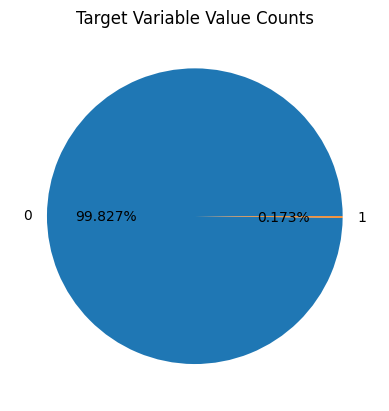

In [3]:
# get the set of distinct classes
label = df.Class.unique()

# Lets count unique values
count_class = df.Class.value_counts()

# Lets represent the result in pie chart
fig, ax = plt.subplots()
ax.pie(count_class, labels=label, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

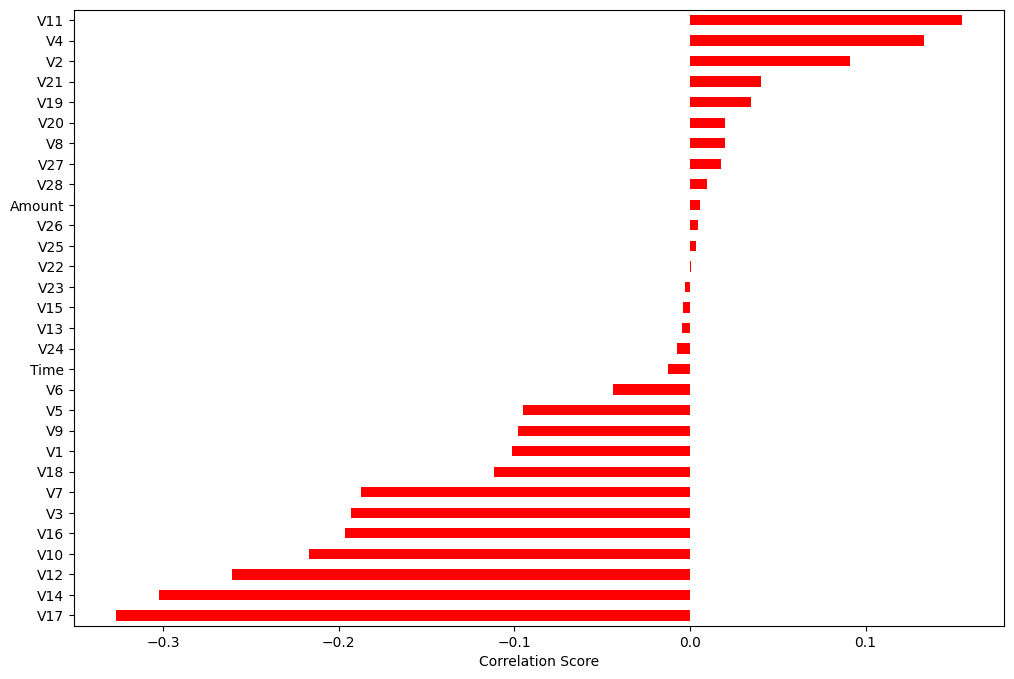

In [4]:
correlation_features = df.corr()['Class'].drop('Class')
correlation_features.sort_values().plot(kind='barh', color='red', figsize=(12, 8))
plt.xlabel('Correlation Score')
plt.show()

## Data Preprocessing
* There is a `Time` feature which we are not going to use

In [5]:
# Standardize data excluding Time and Target Variable
scaler = StandardScaler()
df.iloc[:, 1:30] = scaler.fit_transform(df.iloc[:, 1:30])
data_matrix = df.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]
print(y[9000:9030])

# Normalize the data
X = normalize(X, norm='l1')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Split Train/Test Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build a Decision Tree Classifier model with Scikit-Learn
* Compute the sample weights to be used as input to the train routine so that it takes into account the class imbalance present in this dataset.
* Since `Decision Tree` are not good at considering `class imbalance` i.e. majority of single class (in our case 99.8% and 0.17%). So we need to calculate weight to look for class imbalance such that model do not prioritze the majority class

In [7]:
w_train = compute_sample_weight('balanced', y_train)


**Let's build model**

In [8]:
model = DecisionTreeClassifier(max_depth=4, random_state=35)
model.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

## Build a Support Vector Machine model with Scikit-Learn
* SVM models are good for class imbalance, so we do not need to apply class imbalance i.e. `sample weight`

In [9]:
# for reproducible output across multiple function calls, set random_state to a given integer value
svm = LinearSVC(class_weight='balanced', random_state=35, loss='hinge', fit_intercept=False)
svm.fit(X_train, y_train)


LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=35)

## Evaluate the Decision Tree Classifier Models
Using these probabilities, we can evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score as a metric of model performance. The AUC-ROC score evaluates your model's ability to distinguish positive and negative classes considering all possible probability thresholds. The higher its value, the better the model is considered for separating the two classes of values.

In [10]:
y_pred_dt = model.predict_proba(X_test)[:, 1]

In [11]:
# Calculating roc_auc_score
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print(f'roc_auc_score: {roc_auc_dt:.3f}')

roc_auc_score: 0.939


## Evaluate the Support Vector Machine Models
* Compute the probabilities of the test samples belonging to the class of fraudulent transactions

In [12]:
y_pred_svm = svm.decision_function(X_test)
y_pred_svm

array([27.86531201, -0.49497968, -1.03508223, ..., -0.53898666,
       -1.3128563 ,  4.19154113])

**Let's evaluate SVM model**

In [13]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print(f'roc_auc_score for SVM: {roc_auc_svm:.3f}')

roc_auc_score for SVM: 0.984


**Finding top 6 features in context of correlation**

In [19]:
correlation_values = abs(df.corr()['Class']).drop('Class')
correlation_values = correlation_values.sort_values(ascending=False)[:6].index.to_list()
correlation_values.extend(['Class'])
correlation_values

['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'Class']

## Lets take highly correlated features and reevaluate model i.e. above 6 classes

In [20]:
def selected_features(test_size):
    X_6 = df[correlation_values].values
    X_6 = normalize(StandardScaler().fit_transform(X_6), norm='l1')

    # Train/Test sets
    X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6, y, random_state=42, test_size=test_size)

    weight = compute_sample_weight('balanced', y_train_6)
    model_dt = DecisionTreeClassifier(max_depth=4, random_state=42, criterion='entropy')
    model_dt.fit(X_train_6, y_train_6, sample_weight=weight)

    model_svm = LinearSVC(class_weight='balanced', loss='hinge', fit_intercept=False)
    model_svm.fit(X_train_6, y_train_6)

    y_pred_proba_dt = model_dt.predict_proba(X_test_6)[:, 1]
    print(f'roc_auc_score_dt: {np.round(roc_auc_score(y_test_6, y_pred_proba_dt), 3)}')

    y_pred_proba_svm = model_svm.decision_function(X_test_6)
    print(f'roc_auc_score_svm: {np.round(roc_auc_score(y_test_6, y_pred_proba_svm), 3)}')
selected_features(0.2)

roc_auc_score_dt: 1.0
roc_auc_score_svm: 1.0


## Colclusions from above results
* With a larger set of features, SVM performed relatively better in comparison to the Decision Trees.
* Decision Trees benefited from feature selection and performed better.
* SVMs may require higher feature dimensionality to create an efficient decision hyperplane.